In [1]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import helper

<center><img src = 'Resnet-18.png' width = '250'></center>

# Configs

In [2]:
TRAIN_IMG_DIR = 'data/training/'
TEST_IMG_DIR = 'data/test/'

TRAIN_CSV = 'data/training_frames_keypoints.csv'
TEST_CSV = 'data/test_frames_keypoints.csv'

DEVICE = 'cpu' # 'cuda' - это gpu

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 2
MODEL_NAME = 'resnet18' # 'efficientnet_b0', 'dm_nfnet_f0' .....

# Understand Facial Keypoint Dataset 

In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

train_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


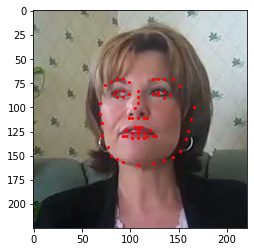

In [4]:
idx = 23

img_name = train_df['Unnamed: 0'].iloc[idx]
img_path = TRAIN_IMG_DIR + img_name
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

key = train_df.iloc[idx][1:].to_numpy().reshape(-1,2) # (136,) -> (68, 2)

plt.imshow(img)
plt.scatter(key[:,0], key[:,1], s = 4, c = 'r')

In [5]:
train_df, valid_df = train_test_split(train_df, test_size = 0.2, random_state = 42)

# Create Custom Facial Keypoint Dataset

albumentation : https://albumentations.ai/docs/  <br>

albumentation for keypoints : https://albumentations.ai/docs/examples/example_keypoints/

In [6]:
import albumentations as A
# крутая библ для аугментации изображений
# приаугментации кей поинтов, при повороте изображения, они тоже поворачиваются
# в отличии от простой классификации

In [7]:
class FacialKeyDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, img_data_dir, augmentations = None):
        self.df = df
        self.img_data_dir = img_data_dir
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        img_name = self.df['Unnamed: 0'].iloc[idx]
        img = cv2.imread(self.img_data_dir + img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        key = self.df.iloc[idx][1:].to_numpy().reshape(-1, 2) # (136,) -> (68,2)
        
        if self.augmentations != None:
            augmented_data = self.augmentations(image = img, keypoints = key)
            img = torch.from_numpy(augmented_data['image']).float()
            key = torch.tensor(augmented_data['keypoints']).float()
            
        return img.permute(2,0,1), key.view(-1) # (H, W, C) - > (C, H, W)| (68, 2) -> (136)
        # т.к. сеть принимает одномерную последовательность

In [8]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    #A.HorizontalFlip(p=0.5)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible = False))

valid_test_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    A.Normalize(),
    #A.HorizontalFlip(p=0.5)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible = False))


In [9]:
trainset = FacialKeyDataset(train_df, TRAIN_IMG_DIR, train_augs)
validset = FacialKeyDataset(valid_df, TRAIN_IMG_DIR, valid_test_augs)
testset = FacialKeyDataset(test_df, TEST_IMG_DIR, valid_test_augs)

In [10]:
print(f"Total no. of examples present in trainset : {len(trainset)}")
print(f"Total no. of examples present in validset : {len(validset)}")

Total no. of examples present in trainset : 2769
Total no. of examples present in validset : 693


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


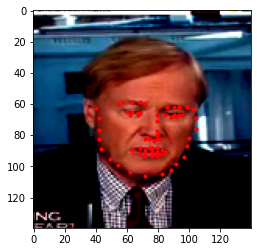

In [11]:
img, key = trainset[17]
helper.imshow_with_key(img, key)

# Load Dataset into Batches 

In [12]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE)

In [13]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 174
Total no. batches in validloader : 44


In [14]:
for data in trainloader:
    image, key = data
    break;

In [15]:
print("Shape of one batch image : {}".format(image.shape))
print("Shape of one batch key : {}".format(key.shape))

Shape of one batch image : torch.Size([16, 3, 140, 140])
Shape of one batch key : torch.Size([16, 136])


# Create Model 

ckeck out timm : https://rwightman.github.io/pytorch-image-models/ (documentation), https://github.com/rwightman/pytorch-image-models (github repo)

In [16]:
import timm

In [17]:
class FacialKeyModel(torch.nn.Module):
    
    def __init__(self, model_name = MODEL_NAME):
        super(FacialKeyModel, self).__init__()
        
        print(f'Loading Backbone: {model_name}')
        self.backbone = timm.create_model(model_name, pretrained = True, num_classes = 136)
        
    def forward(self, images, key = None):
        
        logits = self.backbone(images)
        
        if key != None:
            return logits, torch.nn.MSELoss()(logits, key)
        
        return logits
        

In [18]:
model = FacialKeyModel()
model.to(DEVICE) # для cpu этот шаг можно пропустить

model(torch.rand(16,3,140,140)).shape # проверка что модель работает

Loading Backbone: resnet18


/home/rhyme/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([16, 136])

# Trainer and Evaluator

In [19]:
def train_fn(model, trainloader, optimizer):
    
    train_loss = 0.0
    
    model.train() # как я понял это включение режима обучения
    
    for data in tqdm(trainloader):
        
        images, keys = data
        images, keys = images.to(DEVICE), key.to(DEVICE)
        
        output, loss = model(images, keys)
        
        optimizer.zero_grad()
        loss.backward() # dw, db
        optimizer.step() # w = w -lr*dw, b = ...
        
        train_loss += loss.item()
        
    return train_loss / len(trainloader)

In [20]:
def eval_fn(model, validloader):
    
    valid_loss = 0.0
    
    model.eval() #dropout - скорей всего это отключение dropout, так как у нас тут не обучение
    
    with torch.no_grad():
        for data in tqdm(validloader):
            
            images, keys = data
            images, keys = images.to(DEVICE), keys.to(DEVICE)
            
            output, loss = model(images, keys)
            valid_loss += loss.item()
            
    return valid_loss / len(validloader)

# Training model 

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
best_valid_loss = np.Inf

for i in range(EPOCHS):
    
    avg_train_loss = train_fn(model, trainloader, optimizer)
    avg_valid_loss = eval_fn(model, validloader)
    
    if avg_valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'FacialKeyModel.pt')
        best_valid_loss = avg_valid_loss
        print("MODEL_SAVED")
        
    print(f'Epoch : {i+1} Train_loss : {avg_train_loss}')
    print(f"Epoch : {i+1} Valid_loss : {avg_valid_loss}")

  0%|          | 0/174 [00:00<?, ?it/s]

/home/rhyme/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([16, 136])) that is different to the input size (torch.Size([1, 136])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch : 1 Train_loss : 855.9728728108022
Epoch : 1 Valid_loss : 68.27108825336803


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch : 2 Train_loss : 80.25491960021272
Epoch : 2 Valid_loss : 75.72194801677357


### Model Trained on Google Colab GPU : https://colab.research.google.com/drive/1tQp1IGvM7yQDZ1Weygi40mUfMPHrUd_K?usp=sharing

# Visualizing Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


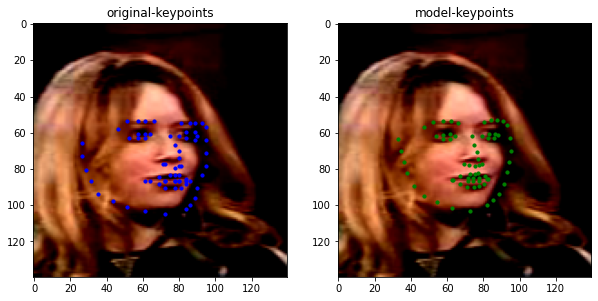

In [26]:
index = 30
image, key = testset[index]

model.load_state_dict(torch.load('[Colab]FacialKeyModel.pt', map_location = DEVICE))
model.eval()
with torch.no_grad():
    image = image.to(DEVICE)
    out_key = model(image.unsqueeze(0)) #
    # модель ожидает(bs, c, h, w), но у нас один пример (c, h, w), поэтому добавляем одно измерение
    helper.compare_keypoints(image, key, out_key)
    

# Optional Task 